# Setup Notebook

## Import Core Libraries for Analysis

In [89]:
# Core libraries
import psycopg2 
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import re

# Libraries for natural language processing (NLP)
import nltk
from nltk.corpus import stopwords
from wordcloud import WordCloud
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.decomposition import LatentDirichletAllocation

nltk.download("stopwords")


[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/MSarker/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

## Get Database Connection

In [90]:
# Get db connection
%run ../utils/connection.py
conn = get_database_connection()

## Load User Feedback

In [91]:
# Load table into pandas
df = pd.read_sql("SELECT * FROM user_feedback;", conn)
df.drop([0, 2], inplace=True) #Drop rows with self testing feedback and with empty feedback

columns = df.columns.tolist()
print(f"List of Columns:- {columns}")
print()
df.info()
df

List of Columns:- ['id', 'username', 'submitted_at', 'role', 'sql_db_experience', 'ai_tools_used', 'ease_of_use', 'response_time', 'layout_intuitiveness', 'query_expression', 'intent_understanding', 'sql_match_intent', 'sql_output_used', 'result_accuracy', 'sql_readability', 'error_description', 'learning_help', 'insight_discovery', 'algorithm_efficiency', 'alt_algorithms', 'alt_algorithm_suggestions', 'analytics_support', 'analytics_usefulness', 'viz_quality', 'analytics_improvements', 'enjoyment', 'reuse_intent', 'recommend_score', 'aware_ai', 'aware_ai_inaccuracy', 'ai_confidence', 'trust_suggestions', 'other_comments']

<class 'pandas.core.frame.DataFrame'>
Index: 6 entries, 1 to 7
Data columns (total 33 columns):
 #   Column                     Non-Null Count  Dtype         
---  ------                     --------------  -----         
 0   id                         6 non-null      int64         
 1   username                   6 non-null      object        
 2   submitted_at   

/var/folders/hk/lh55p5p53zjbnprzzg89y5jc0000gn/T/ipykernel_66756/2112816082.py:2: UserWarning: pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.
  df = pd.read_sql("SELECT * FROM user_feedback;", conn)


,id,username,submitted_at,role,sql_db_experience,ai_tools_used,ease_of_use,response_time,layout_intuitiveness,query_expression,...,viz_quality,analytics_improvements,enjoyment,reuse_intent,recommend_score,aware_ai,aware_ai_inaccuracy,ai_confidence,trust_suggestions,other_comments
1,3,Svetlana,2025-08-28 11:28:14.405572,Financial Adviser,6,Yes,9,10,9,10,...,7,"The tabulated summaries were clearly built, wi...",10,Yes,10,Yes,10,9,Repetitive positive outcomes would increase tr...,It is a well done tool with very good potentia...
3,9,dave,2025-08-29 21:30:33.971367,Administrative Officer,4,No,10,10,6,9,...,7,I think the visualisation features need to be ...,10,Yes,10,Yes,8,9,I think your approach of displaying the SQL qu...,"Impressive, even quite short prompts such as '..."
4,10,test,2025-08-30 15:36:06.294043,Associate Data Engineer,6,Yes,8,10,6,7,...,4,,8,Yes,8,Yes,10,6,the accuracy of the output,"Hi Mohsin! Great job, overall, I was quite imp..."
5,11,J,2025-09-01 15:09:29.572844,Senior Lecturer,7,Yes,9,10,7,10,...,7,I may prefer to see more interactive graph-bas...,8,Yes,10,Yes,10,8,It is based on prompt so need a bit more engin...,I appreciate the overall user experience of th...
6,12,Florentin,2025-09-01 15:53:28.789737,,9,Yes,10,9,9,10,...,8,,9,Yes,9,Yes,8,9,,All the list generated are starting wit positi...
7,13,KHONDOKAR NOMAN,2025-09-01 21:15:29.419726,,5,Yes,7,6,5,5,...,5,,5,Yes,6,Yes,5,6,,


## Quantitative Feedback Analysis

In [92]:
# Mapping column names to the likely intended metrics
quant_cols = [
    'ease_of_use', 'response_time', 'layout_intuitiveness', 'query_expression',
    'intent_understanding', 'sql_match_intent', 'result_accuracy',
    'sql_readability', 'learning_help', 'insight_discovery',
    'algorithm_efficiency', 'analytics_support', 'analytics_usefulness',
    'viz_quality', 'enjoyment', 'reuse_intent', 'recommend_score', 'ai_confidence'
]

# Descriptive statistics
desc_stat = df[quant_cols].describe().T
desc_stat

,count,mean,std,min,25%,50%,75%,max
ease_of_use,6.0,8.833333,1.169045,7.0,8.25,9.0,9.75,10.0
response_time,6.0,9.166667,1.602082,6.0,9.25,10.0,10.00,10.0
layout_intuitiveness,6.0,7.000000,1.673320,5.0,6.00,6.5,8.50,9.0
query_expression,6.0,8.500000,2.073644,5.0,7.50,9.5,10.00,10.0
intent_understanding,6.0,8.166667,2.483277,5.0,6.00,9.5,10.00,10.0
sql_match_intent,6.0,8.333333,2.581989,5.0,6.25,10.0,10.00,10.0
result_accuracy,6.0,8.500000,2.345208,5.0,7.00,10.0,10.00,10.0
sql_readability,6.0,8.666667,1.632993,6.0,8.00,9.0,10.00,10.0
learning_help,6.0,6.500000,1.974842,5.0,5.00,5.5,8.25,9.0
insight_discovery,6.0,6.000000,3.741657,0.0,5.00,5.5,9.00,10.0


## Boxplot

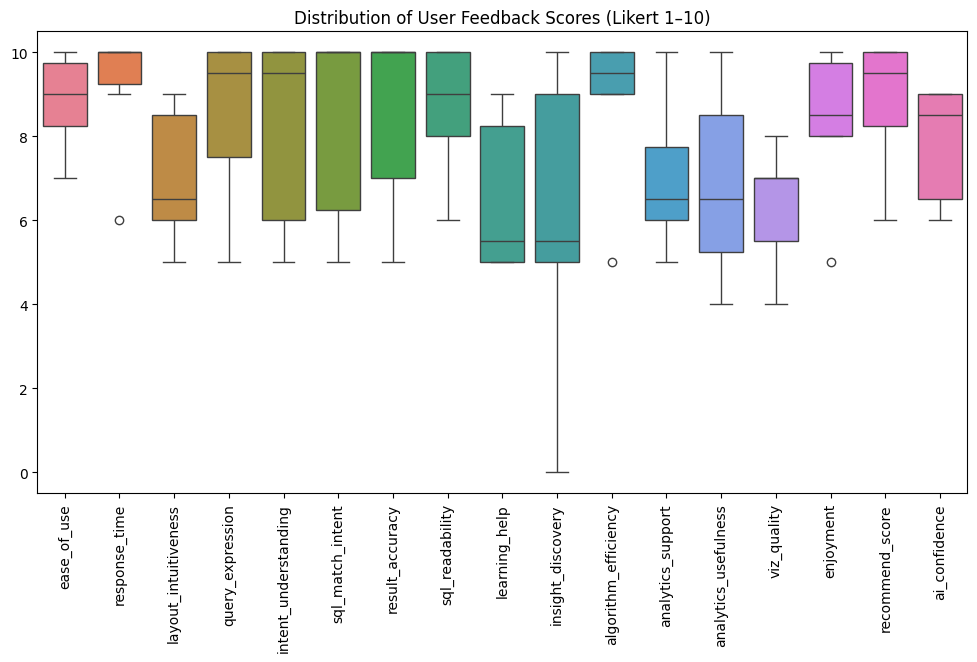

In [93]:
# Boxplot of ratings
plt.figure(figsize=(12,6))
sns.boxplot(data=df[quant_cols])
plt.xticks(rotation=90)
plt.title("Distribution of User Feedback Scores (Likert 1–10)")
plt.show()

## Correlation heatmap

In [96]:
# Convert string or empty value to numeric
df_numeric = df[quant_cols].apply(pd.to_numeric, errors='coerce')
# Fill missing values
df_corr = df_numeric.fillna(df_numeric.mean())

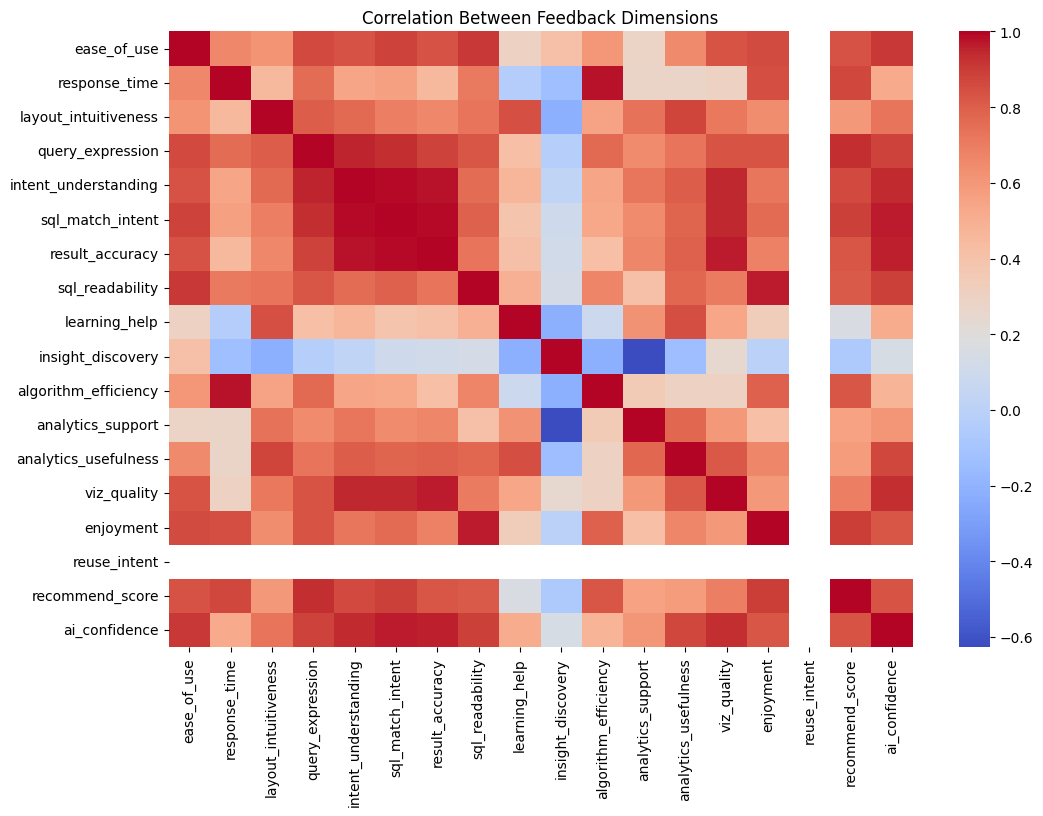

In [104]:
# Correlation heatmap
plt.figure(figsize=(12,8))
sns.heatmap(df_corr.corr(), annot=False, cmap="coolwarm")
plt.title("Correlation Between Feedback Dimensions")
plt.show()

## Text Preprocessing (Comments & Error Descriptions)

In [98]:
stop_words = set(stopwords.words("english"))
text_cols = ["error_description", "alt_algorithm_suggestions", "analytics_improvements", "other_comments"]

# Combine all comment fields into one
df["all_comments"] = df[text_cols].fillna("").agg(" ".join, axis=1)

# Clean text
df["clean_comments"] = df["all_comments"].apply(
    lambda x: " ".join([w for w in re.sub(r"[^a-zA-Z ]","", x.lower()).split() if w not in stop_words])
)

## Word Cloud & Keyword Frequencies

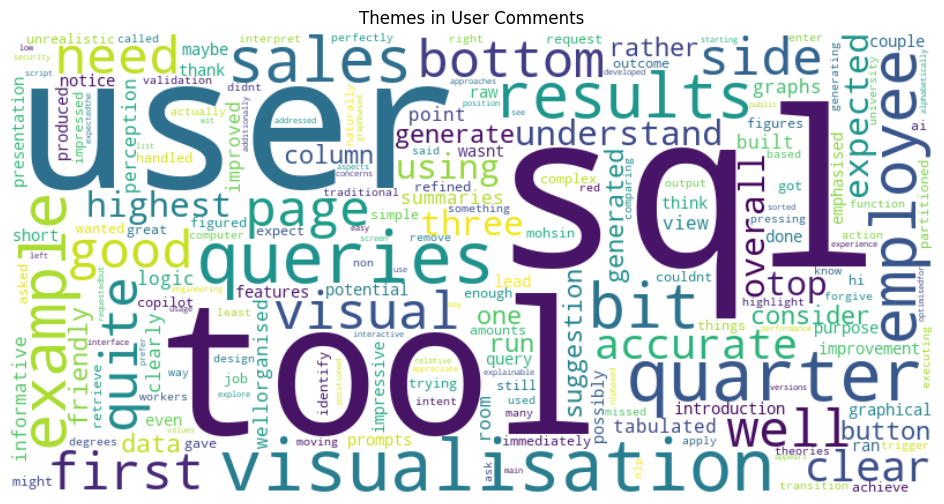

clean_comments
sql               7
tool              5
quarter           4
queries           4
bit               3
results           3
user              3
example           3
sales             3
could             2
page              2
bottom            2
clear             2
accurate          2
top               2
users             2
visualisations    2
first             2
employees         2
understand        2
Name: count, dtype: int64


In [100]:
# Word cloud
text = " ".join(df["clean_comments"])
wordcloud = WordCloud(width=800, height=400, background_color="white").generate(text)

plt.figure(figsize=(12,6))
plt.imshow(wordcloud, interpolation="bilinear")
plt.axis("off")
plt.title("Themes in User Comments")
plt.show()

# Keyword frequencies
top_keywords = df["clean_comments"].str.split().explode().value_counts().head(20)
print(top_keywords)

## Thematic Analysis with Topic Modelling

In [101]:
vectorizer = CountVectorizer(max_df=0.9, min_df=2, stop_words="english")
dtm = vectorizer.fit_transform(df["clean_comments"])

lda = LatentDirichletAllocation(n_components=3, random_state=42)
lda.fit(dtm)

# Print themes
for idx, topic in enumerate(lda.components_):
    print(f"Theme {idx+1}: ", [vectorizer.get_feature_names_out()[i] for i in topic.argsort()[-10:]])


Theme 1:  ['using', 'page', 'accurate', 'quite', 'clear', 'users', 'queries', 'results', 'sales', 'sql']
Theme 2:  ['users', 'consider', 'overall', 'run', 'button', 'using', 'visualisations', 'generated', 'sql', 'tool']
Theme 3:  ['sales', 'visualisations', 'page', 'quite', 'accurate', 'clear', 'tool', 'visualisation', 'queries', 'bit']


## Trust Evaluation

In [102]:
# Trust mapping
trust_mapping = {
    "Reliability / Dependability": ["result_accuracy", "sql_match_intent"],
    "Confidence in System": ["ai_confidence", "reuse_intent", "recommend_score"],
    "Integrity / Security": ["aware_ai", "aware_ai_inaccuracy"]
}

# Calculate average trust scores
trust_scores = {}
for dims, cols in trust_mapping.items():
    valid_cols = [col for col in cols if col in df.columns]
    if valid_cols:
        temp = df[valid_cols].apply(pd.to_numeric, errors="coerce")
        trust_scores[dims] = temp.mean(axis=1).mean()
    else:
        trust_scores[dims] = None

# Compute overall trust score
overall_trust = pd.Series([value for value in trust_scores.values() if value is not None]).mean()

# Create results table
trust_df = pd.DataFrame({
    "Trust Dimension": list(trust_scores.keys()) + ["Overall Trust Score"],
    "Average Score (out of 10)": list(trust_scores.values()) + [overall_trust]
})

print("\nAggregated User Trust Scores (TIAS-style):\n")
print(trust_df.round(2))


Aggregated User Trust Scores (TIAS-style):

               Trust Dimension  Average Score (out of 10)
0  Reliability / Dependability                       8.42
1         Confidence in System                       8.33
2         Integrity / Security                       8.50
3          Overall Trust Score                       8.42


## Trust / TIAS Dimensions

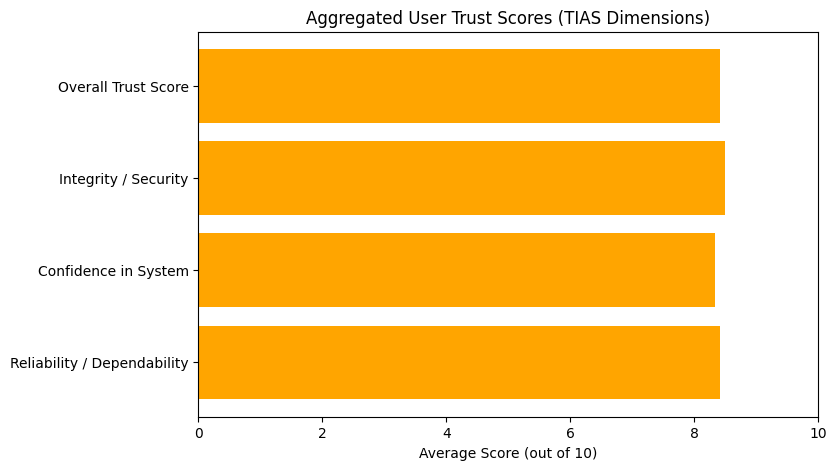

In [103]:
# Optional: visualization
plt.figure(figsize=(8,5))
plt.barh(trust_df["Trust Dimension"], trust_df["Average Score (out of 10)"], color="orange")
plt.xlim(0,10)
plt.xlabel("Average Score (out of 10)")
plt.title("Aggregated User Trust Scores (TIAS Dimensions)")
plt.show()